In [1]:
import numpy as np
import warnings 

warnings.filterwarnings('ignore')

class ManualNaiveBayes:
    
    def fit(self, X, y):
        self._unique_classes = np.unique(y)
        self._class_statistics = {}
        total_samples = X.shape[0] 

        for current_class_label in self._unique_classes:
            samples_in_current_class = X[y == current_class_label]
            
            mean_features = samples_in_current_class.mean(axis=0)
            # Aggiungiamo un piccolo valore per evitare divisioni per zero
            variance_features = samples_in_current_class.var(axis=0) + 1e-5
            
            # Calcola la probabilità a priori di questa classe
            prior_probability = samples_in_current_class.shape[0] / float(total_samples)
            
            self._class_statistics[current_class_label] = {
                'mean': mean_features,
                'variance': variance_features,
                'prior_prob': prior_probability
            }
    
    def _calculate_gaussian_pdf(self, features, mean, variance):
    
        numerator = np.exp(- (features - mean)**2 / (2 * variance))
        denominator = np.sqrt(2 * np.pi * variance)
        return numerator / denominator
    
    def _predict_single_sample(self, sample_features):

        log_posteriors_per_class = []

        for class_label in self._unique_classes:
            stats = self._class_statistics[class_label]
            
            log_prior = np.log(stats['prior_prob'])
            
            # Somma dei logaritmi delle PDF delle singole feature
            log_likelihood = np.sum(np.log(
                self._calculate_gaussian_pdf(sample_features, stats['mean'], stats['variance'])
            ))
            
            # La probabilità a posteriori logaritmica è la somma del log-prior e del log-likelihood
            total_log_posterior = log_prior + log_likelihood
            log_posteriors_per_class.append(total_log_posterior)
        
        # Restituisce la classe con la probabilità a posteriori logaritmica più alta
        predicted_index = np.argmax(log_posteriors_per_class)
        return self._unique_classes[predicted_index]

    def predict(self, X):
        predictions = []
        for sample_features in X:
            # Delega la previsione del singolo campione al metodo ausiliario
            predicted_class = self._predict_single_sample(sample_features)
            predictions.append(predicted_class)
            
        return np.array(predictions)

In [2]:
class ManualKNN:
    # ... (codice del classificatore KNN come prima)
    def __init__(self, k=3): 
        self.k = k

    def fit(self, X, y): 
        self.X_train, self.y_train = X, y
        
    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])
        
    def _predict_single(self, x):
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return Counter(k_nearest_labels).most_common(1)[0][0]

In [3]:
import numpy as np
import pandas as pd
from collections import Counter

class SimpleDecisionTreeClassifier:
    """Costruzione manuale di un albero decisionale per classificazione."""

    def __init__(self, max_levels=5, min_samples=2):
        self.max_levels = max_levels
        self.min_samples = min_samples
        self.root = None
        self.label_encoder = {}
        self.label_decoder = []

    def train(self, features, labels):
        self.label_decoder = np.unique(labels)
        self.label_encoder = {label: idx for idx, label in enumerate(self.label_decoder)}
        encoded_labels = np.array([self.label_encoder[label] for label in labels])

        self.n_attributes = features.shape[1]
        self.root = self._build_node(features, encoded_labels, level=0)

    def classify(self, features):
        predictions = [self.label_decoder[self._classify_row(row, self.root)] for row in features]
        return np.array(predictions)

    def _classify_row(self, row, node):
        while "attribute" in node:
            if row[node["attribute"]] < node["cutoff"]:
                node = node["left_branch"]
            else:
                node = node["right_branch"]
        return node["class"]

    def _build_node(self, data, labels, level):
        num_samples = len(labels)
        unique_classes = np.unique(labels)

        # Condizioni di arresto
        if level >= self.max_levels or num_samples < self.min_samples or len(unique_classes) == 1:
            return {"class": self._most_frequent_class(labels)}

        best_attr, best_split = self._find_optimal_split(data, labels)
        if best_attr is None:
            return {"class": self._most_frequent_class(labels)}

        mask_left = data[:, best_attr] < best_split
        mask_right = ~mask_left

        if np.sum(mask_left) == 0 or np.sum(mask_right) == 0:
            return {"class": self._most_frequent_class(labels)}

        left_subtree = self._build_node(data[mask_left], labels[mask_left], level + 1)
        right_subtree = self._build_node(data[mask_right], labels[mask_right], level + 1)

        return {
            "attribute": best_attr,
            "cutoff": best_split,
            "left_branch": left_subtree,
            "right_branch": right_subtree
        }

    def _find_optimal_split(self, data, labels):
        best_gain = -np.inf
        best_attr = None
        best_value = None

        for i in range(self.n_attributes):
            values = np.unique(data[:, i])
            for val in values:
                gain = self._calculate_gain(data, labels, i, val)
                if gain > best_gain:
                    best_gain = gain
                    best_attr = i
                    best_value = val
        return best_attr, best_value

    def _calculate_gain(self, data, labels, attr_index, threshold):
        full_entropy = self._compute_entropy(labels)
        mask = data[:, attr_index] < threshold
        left_labels, right_labels = labels[mask], labels[~mask]

        if len(left_labels) == 0 or len(right_labels) == 0:
            return 0

        weight_left = len(left_labels) / len(labels)
        weight_right = len(right_labels) / len(labels)
        entropy_split = (
            weight_left * self._compute_entropy(left_labels)
            + weight_right * self._compute_entropy(right_labels)
        )

        return full_entropy - entropy_split

    def _compute_entropy(self, labels):
        if len(labels) == 0:
            return 0
        counts = np.bincount(labels)
        probs = counts[counts > 0] / len(labels)
        return -np.sum(probs * np.log2(probs))

    def _most_frequent_class(self, labels):
        return Counter(labels).most_common(1)[0][0]

    

Anteprima dataset manuale:
   profile id  #friends  #following  #community  age  #postshared  #urlshared  \
0           1        39         300         907  200         1000         850   
1           2       150         350          30  300          300         100   
2           3       300         450          50  465          500         150   
3           4        25         110         660  350         2050        2000   
4           5        24         100         150  800          950        1000   

   #photos/videos  fpurls  fpphotos/videos  avgcomment/post  likes/post  \
0             922   0.850            0.922               56          47   
1             290   0.333            0.967                5          12   
2             450   0.300            0.900                4          15   
3            2050   0.976            1.000                7           3   
4             900   1.053            0.947               66           5   

   tags/post  #tags/post  Label  
0

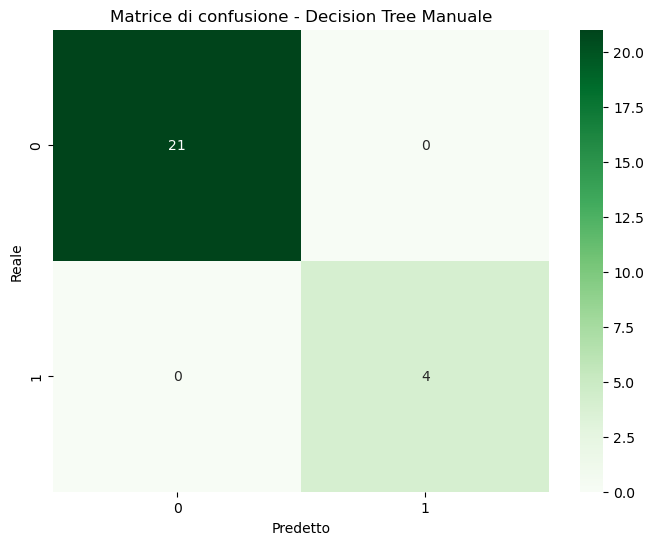

Naive Bayes Manuale - Accuracy: 0.960


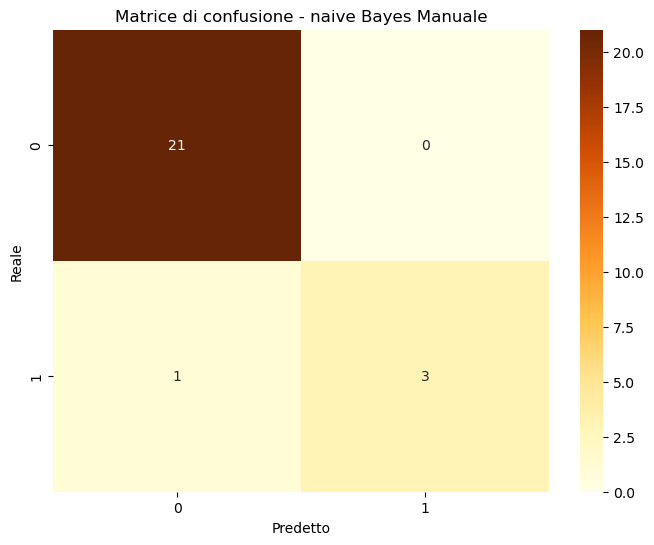


Manual KNN - Accuracy: 0.920


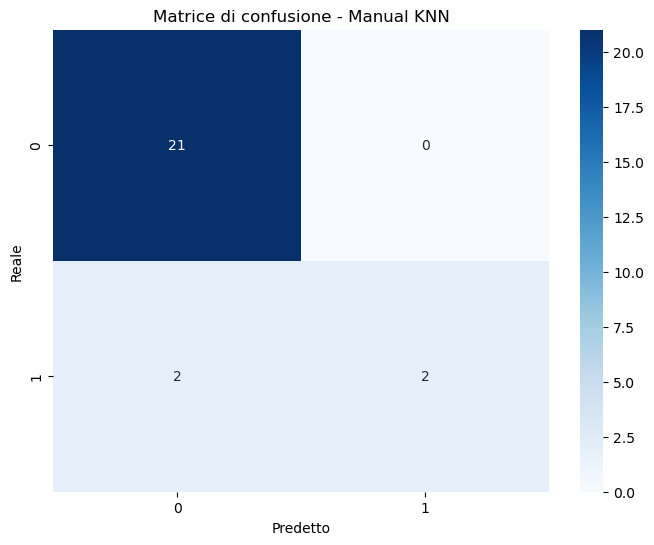


Migliore classificatore manuale: Decision tree
Data Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00         4

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Data Naive Bayes

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.75      0.86         4

    accuracy                           0.96        25
   macro avg       0.98      0.88      0.92        25
weighted avg       0.96      0.96      0.96        25

Data KNN

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.50      0.67         4

    accuracy                           0.92        25
   macro avg       0.96      0.7

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

manuale_df = pd.read_csv('clean_manual.csv', sep = ';')
print("Anteprima dataset manuale:")
print(manuale_df.head())



feature_cols = ['#friends', '#following', '#community', 'age', '#postshared', '#urlshared', '#photos/videos', 'fpurls',
                'fpphotos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post' ]
X_manuale = manuale_df[feature_cols].values
y_manuale = manuale_df['Label'].values

scaler = StandardScaler()

X_manuale_scaled = scaler.fit_transform(X_manuale)


print(f"\nDimensioni dataset: {X_manuale.shape}")
print(f"Classi presenti: {np.unique(y_manuale)}")


loo = LeaveOneOut()


#test decision tree
dt_scores = []
dt_predictions = []
dt_true = []

for train_idx, test_idx in loo.split(X_manuale):
    X_train_loo, X_test_loo = X_manuale[train_idx], X_manuale[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    dt = SimpleDecisionTreeClassifier(max_levels = 5, min_samples = 2)
    dt.train(X_train_loo, y_train_loo)
    pred = dt.classify(X_test_loo)

    dt_predictions.extend(pred)
    dt_true.extend(y_test_loo)
    dt_scores.append(pred[0] == y_test_loo[0])

dt_accuracy = np.mean(dt_scores)
print(f"\nDecision Tree Manuale - Accuracy: {dt_accuracy:.3f}")


plt.figure(figsize=(8, 6))
cm = confusion_matrix(dt_true, dt_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Decision Tree Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()


#test naive-bayes

nb_scores = []
nb_predictions = []
nb_true = []

for train_idx, test_idx in loo.split(X_manuale_scaled):
    X_train_loo, X_test_loo = X_manuale_scaled[train_idx], X_manuale_scaled[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    nb = ManualNaiveBayes()
    nb.fit(X_train_loo, y_train_loo)
    pred = nb.predict(X_test_loo)

    nb_predictions.append(pred[0])
    nb_true.append(y_test_loo[0])
    nb_scores.append(pred[0] == y_test_loo[0])


nb_accuracy = np.mean(nb_scores)
print(f"Naive Bayes Manuale - Accuracy: {nb_accuracy:.3f}")


plt.figure(figsize=(8, 6))
cm = confusion_matrix(nb_true, nb_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=np.unique(y_manuale), 
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - naive Bayes Manuale')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

#test KNN

knn_scores = []
knn_predictions = []
knn_true = []

for train_idx, test_idx in loo.split(X_manuale):
    X_train_loo, X_test_loo = X_manuale[train_idx], X_manuale[test_idx]
    y_train_loo, y_test_loo = y_manuale[train_idx], y_manuale[test_idx]

    knn = ManualKNN(k=3)
    knn.fit(X_train_loo, y_train_loo)
    pred = knn.predict(X_test_loo)

    knn_predictions.extend(pred)
    knn_true.extend(y_test_loo)
    knn_scores.append(pred[0] == y_test_loo[0])

knn_accuracy = np.mean(knn_scores)
print(f"\nManual KNN - Accuracy: {knn_accuracy:.3f}")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(knn_true, knn_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_manuale),
            yticklabels=np.unique(y_manuale))
plt.title('Matrice di confusione - Manual KNN')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()


print(f"\nMigliore classificatore manuale: {'Naive Bayes' if nb_accuracy > dt_accuracy > knn_accuracy else 
                                                'KNN' if knn_accuracy > dt_accuracy > nb_accuracy else
                                                'Decision tree'}")


print('Data Decision Tree\n') 
print(classification_report(dt_true, dt_predictions))
print('Data Naive Bayes\n')
print(classification_report(nb_true, nb_predictions))
print('Data KNN\n')
print(classification_report(knn_true, knn_predictions))

Train: (439, 13), Test: (110, 13)
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.965
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.965
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.964
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.954
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.954
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.956
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.949
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.951
max_depth=[3, 5, 10], min_split=[2, 3, 5] --> acc=0.954

Decision Tree Manuale - Accuracy: 0.945
Report di classificazione Decision Tree Manuale:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97        98
         1.0       0.71      0.83      0.77        12

    accuracy                           0.95       110
   macro avg       0.85      0.90      0.87       110
weighted avg       0.95      0.95      0.95       110



<Figure size 800x600 with 0 Axes>

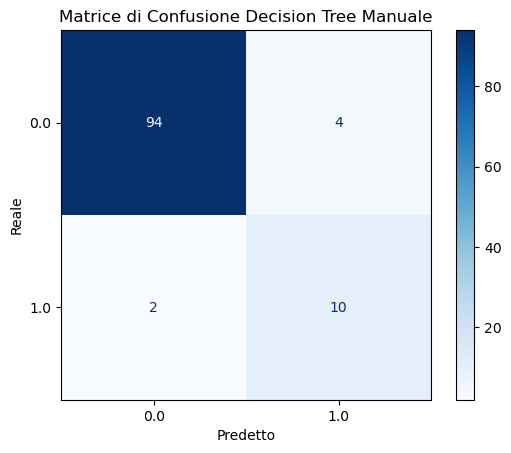


Naive Bayes Manuale - Accuracy: 0.964
Report di classificazione Naive Bayes Manuale:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        98
         1.0       0.83      0.83      0.83        12

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110



<Figure size 800x600 with 0 Axes>

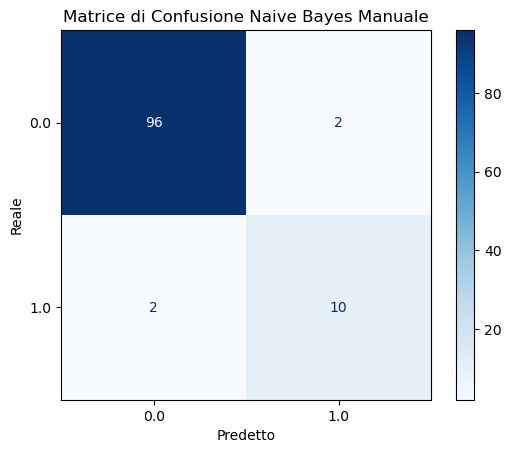

K=3 --> Accuracy media: 0.973
K=6 --> Accuracy media: 0.971
K=9 --> Accuracy media: 0.974

ManualKNN - Accuracy: 0.964
Report di classificazione KNN Manuale:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        98
         1.0       0.83      0.83      0.83        12

    accuracy                           0.96       110
   macro avg       0.91      0.91      0.91       110
weighted avg       0.96      0.96      0.96       110



<Figure size 800x600 with 0 Axes>

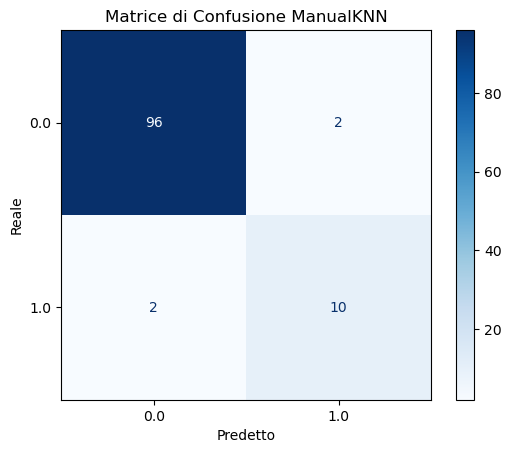

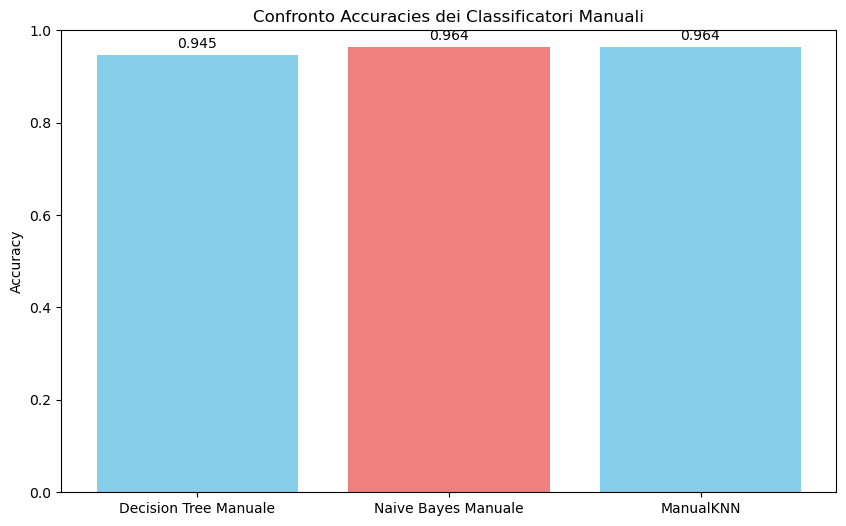

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

training_df = pd.read_csv('training_manual.csv', sep = ';')

feature_cols = ['#friends', '#following', '#community', 'age', '#postshared', '#urlshared', '#photos/videos', 'fpurls',
                'fpphotos/videos', 'avgcomment/post', 'likes/post', 'tags/post', '#tags/post']

X = training_df[feature_cols].values
y = training_df['Label'].values


#la normalizzazione serve solo per Naive Bayes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split sul set normalizzato
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


print(f"Train: {X_train.shape}, Test: {X_test.shape}")

#test sul Decision tree, testiamo diverse profondità essendo il set ampio

max_levels = [3, 5, 10]
min_samples = [2, 3, 5]

results_dt = []

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for max_level in max_levels:
    for min_sample in min_samples:
        accuracies_dt = []

        for train_idx, val_idx in cv.split(X, y):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            model = SimpleDecisionTreeClassifier(max_levels = max_level, min_samples = min_sample)
            model.train(X_train_cv, y_train_cv)
            y_pred = model.classify(X_val_cv)

            acc = accuracy_score(y_val_cv, y_pred)
            accuracies_dt.append(acc)

        mean_acc = np.mean(accuracies_dt)
        results_dt.append({
            'max_levels': max_levels,
            'min_samples_split': min_samples,
            'mean_accuracy': mean_acc
        })
        print(f"max_depth={max_levels}, min_split={min_samples} --> acc={mean_acc:.3f}")


dt = SimpleDecisionTreeClassifier(max_levels=5, min_samples=5)
dt.train(X_train, y_train)
dt_pred = dt.classify(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"\nDecision Tree Manuale - Accuracy: {dt_acc:.3f}")
print("Report di classificazione Decision Tree Manuale:")
print(classification_report(y_test, dt_pred))

# Confusion matrix decision tree
cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Greens', values_format='d')
plt.title("Matrice di Confusione Decision Tree Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


# Test Naive Bayes manuale
nb = ManualNaiveBayes()
nb.fit(X_trainS, y_trainS)
nb_pred = nb.predict(X_testS)
nb_acc = accuracy_score(y_testS, nb_pred)

print(f"\nNaive Bayes Manuale - Accuracy: {nb_acc:.3f}")
print("Report di classificazione Naive Bayes Manuale:")
print(classification_report(y_testS, nb_pred))

# Confusion matrix Bayes
cm_bayes = confusion_matrix(y_testS, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='YlOrBr', values_format='d')
plt.title("Matrice di Confusione Naive Bayes Manuale")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


k_values = [3, 6, 9]

results_knn = []

for k in k_values:
    accuracies_knn = []

    for train_idx, val_idx in cv.split(X_scaled, y):  
        X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]

        # Inizializza e addestra KNN manuale
        knn = ManualKNN(k=k)
        knn.fit(X_train_cv, y_train_cv)
        y_pred = knn.predict(X_val_cv)

        acc = accuracy_score(y_val_cv, y_pred)
        accuracies_knn.append(acc)

    mean_acc = np.mean(accuracies_knn)
    results_knn.append({'k': k, 'mean_accuracy': mean_acc})
    print(f"K={k} --> Accuracy media: {mean_acc:.3f}")



knn = ManualKNN(k = 3)
knn.fit(X_trainS, y_trainS)
knn_pred = knn.predict(X_testS)
knn_acc = accuracy_score(y_testS, knn_pred)

print(f"\nManualKNN - Accuracy: {knn_acc:.3f}")
print("Report di classificazione KNN Manuale:")
print(classification_report(y_testS, knn_pred))

cm_knn = confusion_matrix(y_testS, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=np.unique(y_testS))
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice di Confusione ManualKNN")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


# Confronto visivo delle performance
plt.figure(figsize=(10, 6))
labels = ['Decision Tree Manuale', 'Naive Bayes Manuale', 'ManualKNN']
accuracies = [dt_acc, nb_acc, knn_acc]
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Confronto Accuracies dei Classificatori Manuali')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Aggiungiamo le etichette di accuracy sopra le barre
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()